# t-dependent injection

In [16]:
%reset -f

import ROOT, numpy

ROOT.gErrorIgnoreLevel = ROOT.kWarning

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetPadRightMargin(0.01)
ROOT.gStyle.SetPadLeftMargin(0.075)
ROOT.gStyle.SetPadBottomMargin(0.12)

ROOT.gStyle.SetTitleFont(42,'xy')
ROOT.gStyle.SetTitleFont(42,'T')
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetTitleSize(0.1, 'T')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.58, 'Y')
ROOT.gStyle.SetLabelFont(42,'xy')
ROOT.gStyle.SetLabelSize(0.07, 'XY')

ROOT.gStyle.SetMarkerSize(2)
ROOT.TH1.AddDirectory(0)



%run -i eppi0_columns.py
%run -i eppi0_binning_scheme_v3.py
%run -i eppi0_bsa.py


dfs = []

for fname in ["data/lvl2_eppi0.inb.mc.smear.eloss.root","data/lvl2_eppi0.outb.mc.smear.eloss.root"]:
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)

    cut = "&&".join(f"(((int)status)&(1<<{i}))" for i in [ecloose,prodc,gloosest])
    cut += "&& abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4"
    cut += "&& abs(dpt)<0.3"
    cut += "&& thp<44.106+-6.625*pp+1.438*pp*pp"

    df = df.Filter(cut)
    df = define_eppi0_bins(df, fname)
    
    if 'ihel' not in list(df.GetColumnNames()):
        pb = 0.86 if 'inb' in fname else 0.89
        df = df.Define("ihel", f"""
        TLorentzVector pro0(0,0,0,0), targ(0,0,0,0.938);
        pro0.SetXYZM(px0,py0,pz0,0.938);
        
        double mt0 = -(pro0-targ).M2();
        double alu = 0.1+0.1*mt0/2;
        
        if(iqx==0)
            alu = 0.0488*sqrt(mt0+0.1034);
        else if(iqx==1)
            alu = 0.0422*sqrt(mt0+0.1403);
        else if(iqx==2)
            alu = 0.0663*sqrt(mt0+0.1908);
        else if(iqx==3)
            alu = 0.0361*sqrt(mt0+0.3296);
        else if(iqx==4)
            alu = 0.0497*sqrt(mt0+0.6594);

        return gRandom->Rndm()>(0.5*(1+{pb}*alu*sin(phistar0*TMath::DegToRad()))) ? 1 : -1;
        """)

    df = process_eppi0_bins(df, fname)
    dfs.append((df))


rdfs = [] 
for rdf in dfs:
    make_allbsas(rdf)
    rdfs.append(rdf)


In [17]:
def xshift(gr0, dx=0):
    for i in range(gr0.GetN()):
        gr0.SetPointX(i, gr0.GetPointX(i)+dx)
    return gr0



with open("main.output.data") as ff:
    grsdata = eval(ff.read())

maingrs = []
for grdata in grsdata:
    gr = ROOT.TGraphErrors()
    for x,y,dy in grdata:
        gr.SetPoint(gr.GetN(), x, y)
        gr.SetPointError(gr.GetN()-1, 0, dy)
    gr.Sort()
    maingrs.append(gr)
    

___________________________________________________
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


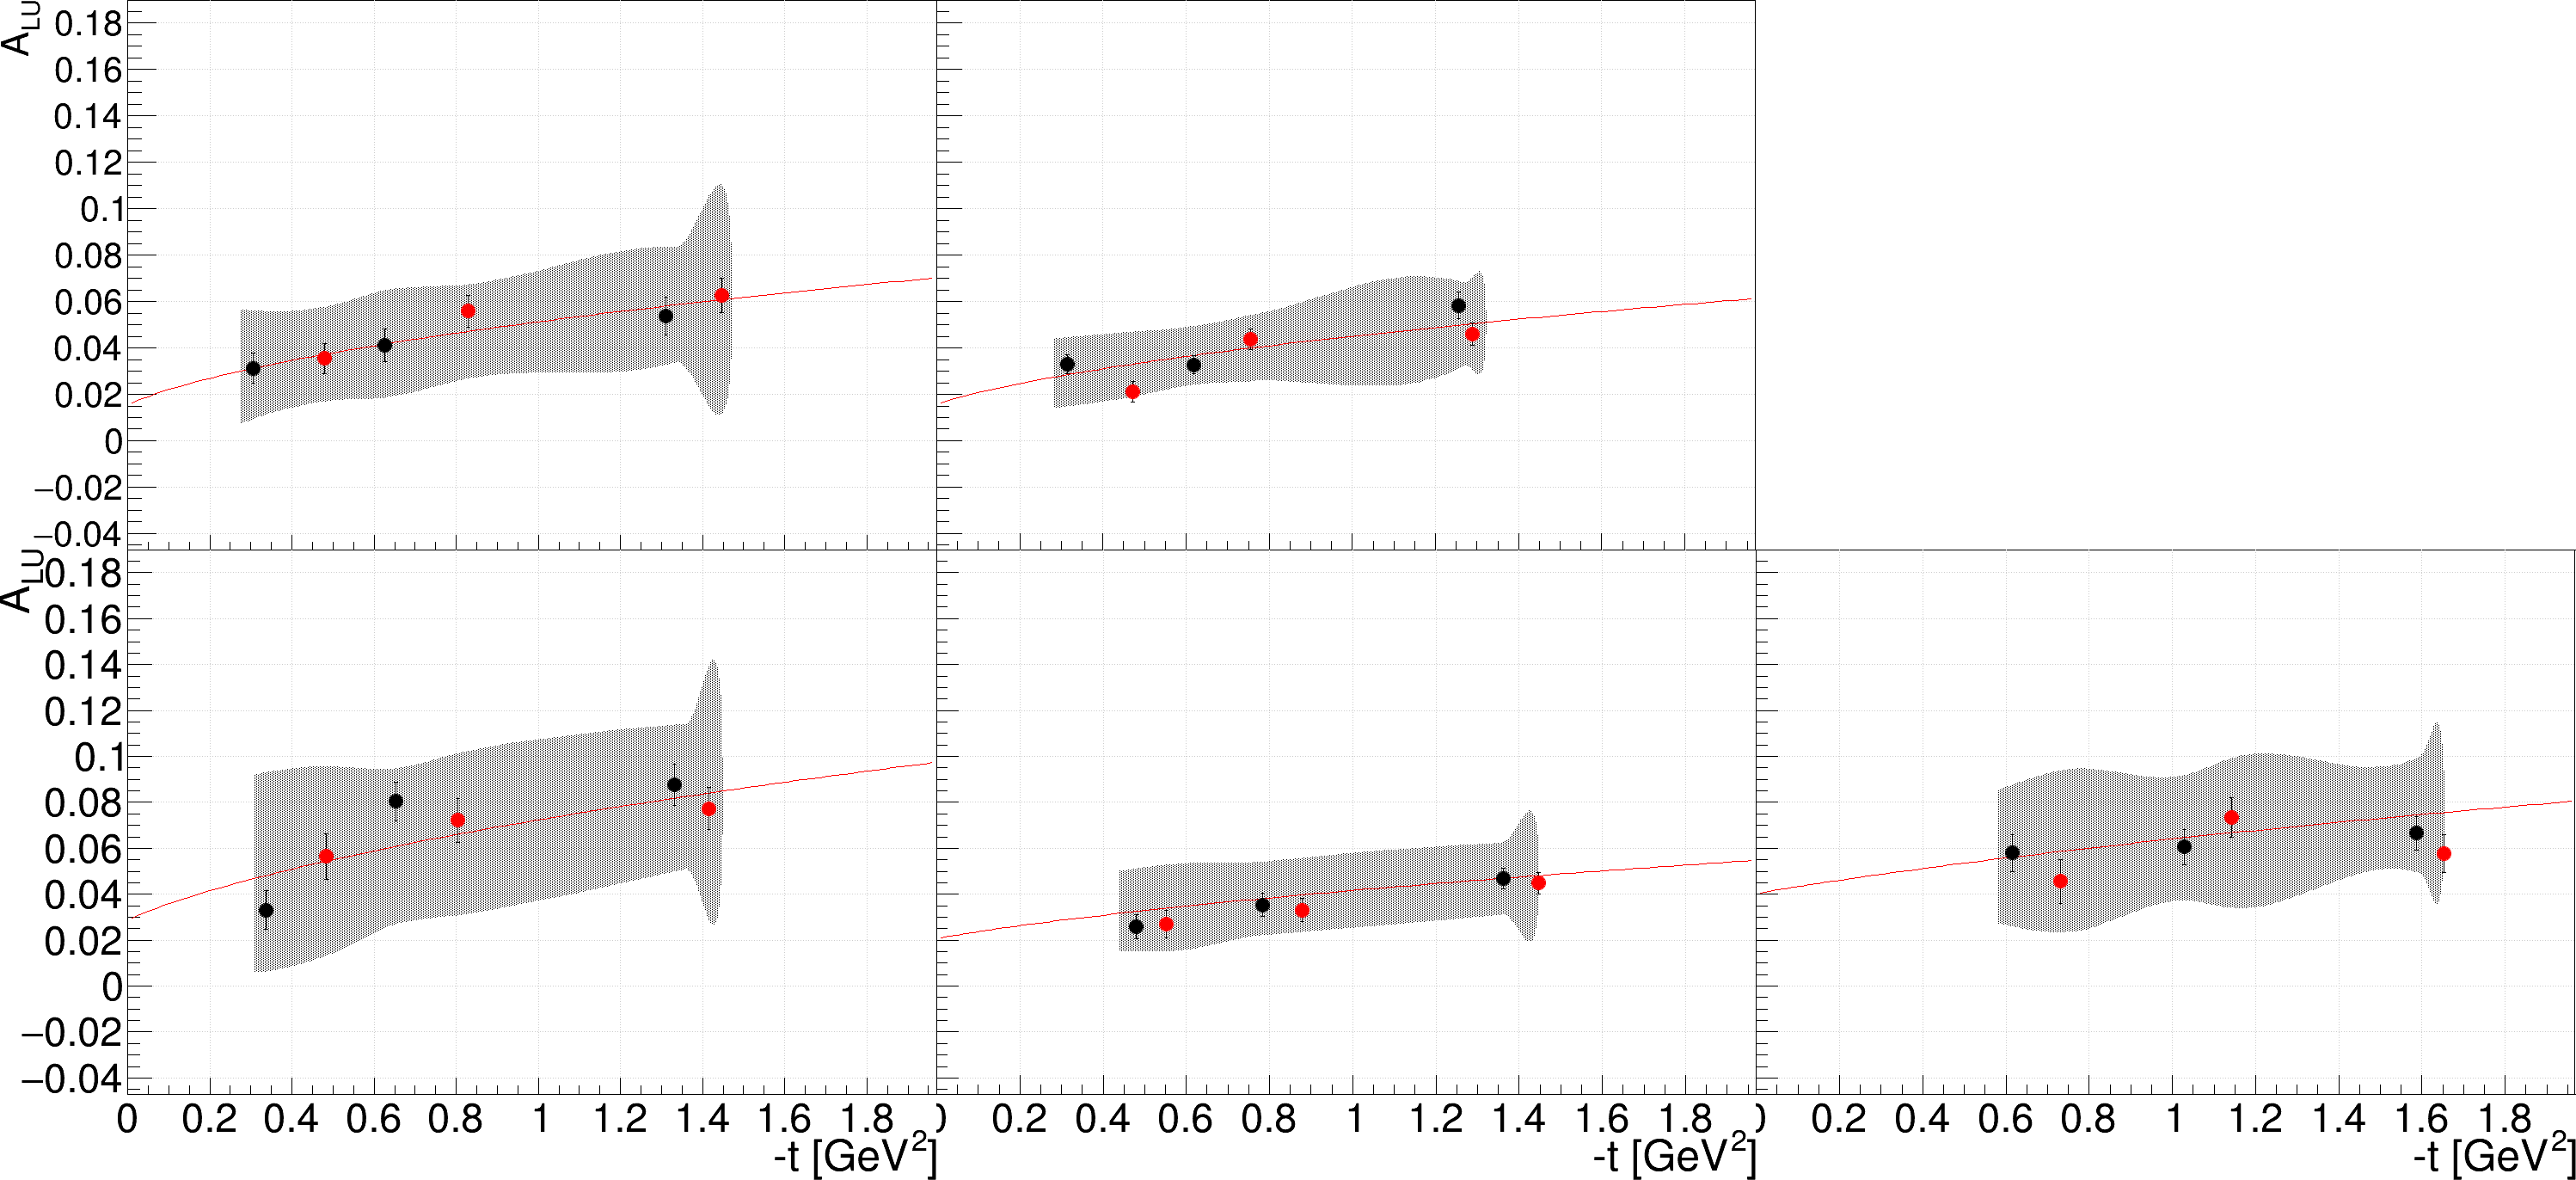

In [22]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

imc,omc = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []
f1s = [ROOT.TF1("f1",line,0,2) for line in ["0.0488*sqrt(x+0.1034)", "0.0422*sqrt(x+0.1403)", "0.0663*sqrt(x+0.1908)", "0.0361*sqrt(x+0.3296)", "0.0497*sqrt(x+0.6594)"]]
if1=ipad=0

systs = []

for iqdf in imc.qdfs:
    bid = iqdf.binid
    iqdf = imc.shards[bid]
    oqdf = omc.shards[bid]
    
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()
    for i in range(3):
        xx = gr0.GetPointX(i)
        systs.append((0, i, xx, abs(gr0.GetPointY(i) - f1s[if1].Eval(xx))))
        xx = gr1.GetPointX(i)
        systs.append((1, i, xx, abs(gr1.GetPointY(i) - f1s[if1].Eval(xx))))

    grstat = ROOT.TGraphErrors()
    for ip in range(maingrs[if1].GetN()):
        xx = maingrs[if1].GetPointX(ip)
        grstat.SetPoint(ip, xx-0.05*(ip==0), f1s[if1].Eval(xx))
        grstat.SetPointError(ip, 0, maingrs[if1].GetErrorY(ip))
    grstat.SetFillColor(1);
    grstat.SetFillStyle(3002);
    grstat.Draw("4")
    grs.append(grstat)

    f1s[if1].SetLineWidth(1)
    f1s[if1].Draw('same')
    if1+=1

    gr0.Draw("P")
    gr1.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)
    gr1.SetMarkerColor(2)

with open("MC_injected_asymmetry.tdep.dat", 'w') as ff:
    ff.writelines([str(en)+"\n" for en in systs])
    
c1.Print("pdf/MC_injected_asymmetry.tdep.pdf")

____________________
### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


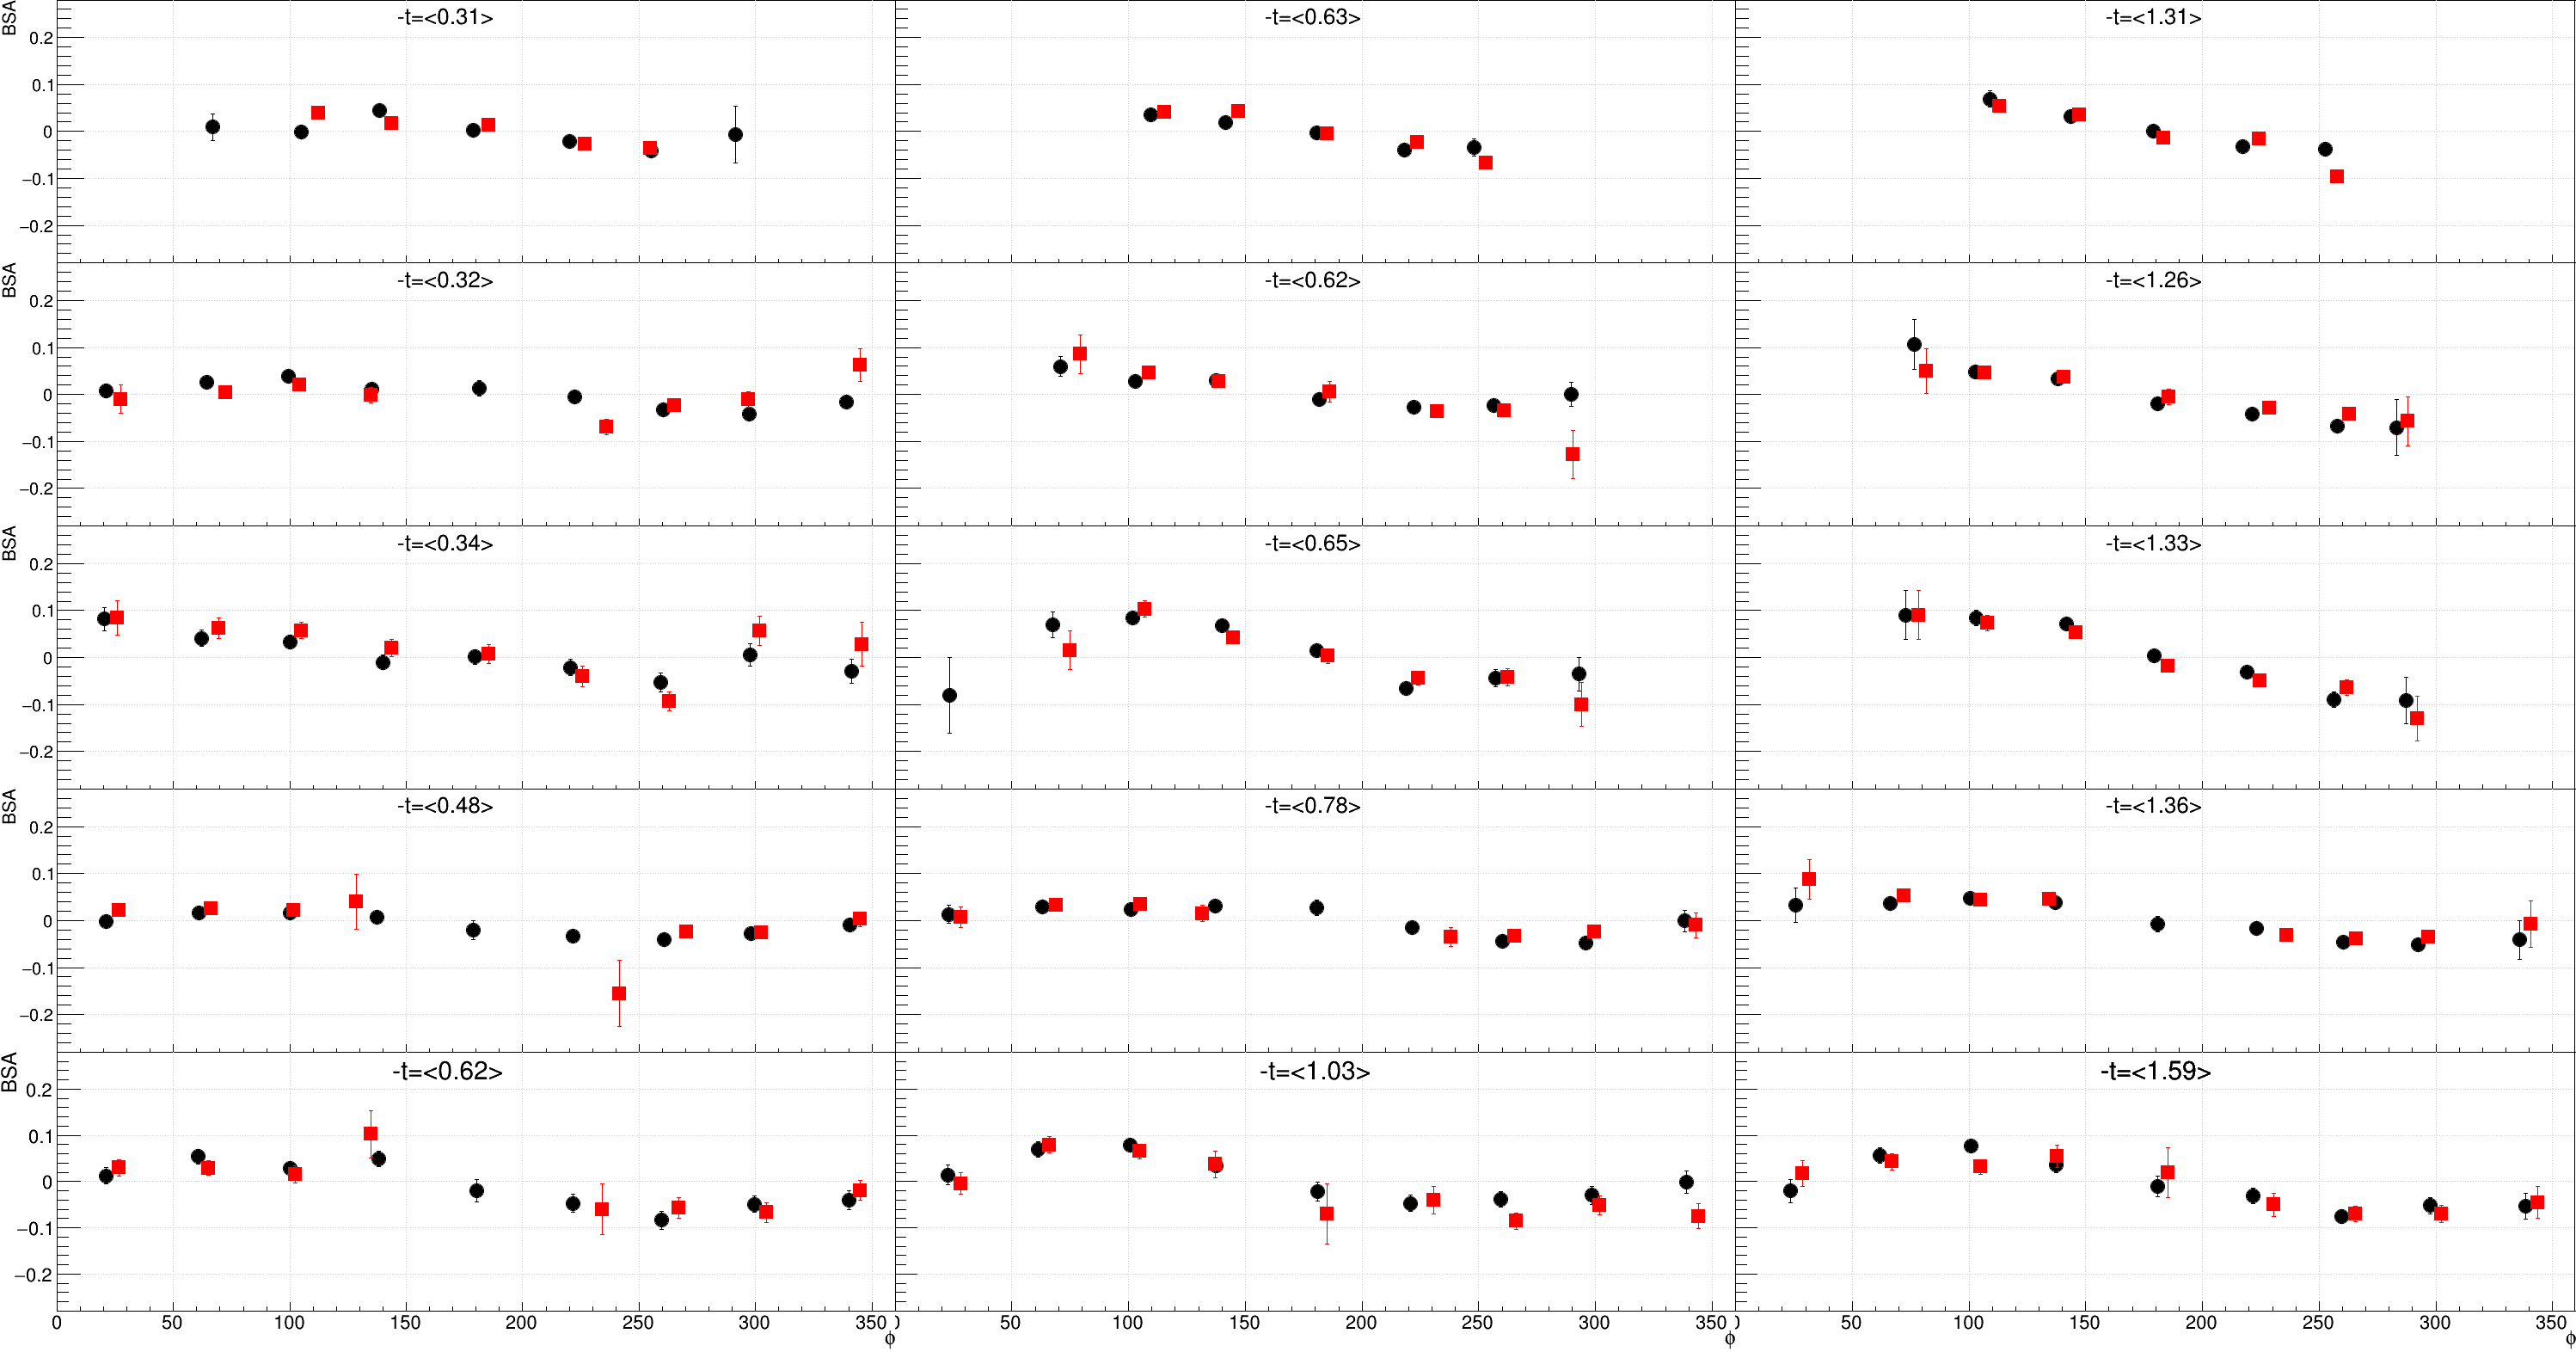

In [20]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

imc,omc = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)

grs = []

ipad=0
for iqdf in imc.qdfs:
    for itdf in iqdf.tdfs:
        bid = itdf.binid
        otdf = omc.shards[bid]

        ipad+=1
        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(itdf.tt,2)}>;#phi;BSA")
        
        gr0, gr1 = itdf.grbsa.Clone(), xshift(otdf.grbsa.Clone(), 5)

        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)
        

________________________________

________________________________

________________________________

# AAORAD: t-dependent injection

In [5]:
%reset -f

import ROOT, numpy

ROOT.gErrorIgnoreLevel = ROOT.kWarning

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetPadRightMargin(0.01)
ROOT.gStyle.SetPadLeftMargin(0.075)
ROOT.gStyle.SetPadBottomMargin(0.12)

ROOT.gStyle.SetTitleFont(42,'xy')
ROOT.gStyle.SetTitleFont(42,'T')
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetTitleSize(0.1, 'T')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.58, 'Y')
ROOT.gStyle.SetLabelFont(42,'xy')
ROOT.gStyle.SetLabelSize(0.07, 'XY')

ROOT.gStyle.SetMarkerSize(2)
ROOT.TH1.AddDirectory(0)



%run -i eppi0_columns.py
%run -i eppi0_binning_scheme_v3.py
%run -i eppi0_bsa.py


dfs = []

for fname in ["data/lvl2_eppi0.inb.mc.aaorad.smear.eloss.root","data/lvl2_eppi0.outb.mc.aaorad.smear.eloss.root"]:
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)
    
    cut = "&&".join(f"(((int)status)&(1<<{i}))" for i in [ecloose,prodc,gloosest])
    cut += "&& abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4"
    cut += "&& abs(dpt)<0.3"
    cut += "&& thp<44.106+-6.625*pp+1.438*pp*pp"

    df = df.Filter(cut)
    df = define_eppi0_bins(df, fname)
    
    if 'ihel' not in list(df.GetColumnNames()):
        pb = 0.86 if 'inb' in fname else 0.89
        df = df.Define("ihel", f"""
        TLorentzVector pro0(0,0,0,0), targ(0,0,0,0.938);
        pro0.SetXYZM(px0,py0,pz0,0.938);
        
        double mt0 = -(pro0-targ).M2();
        double alu = 0.1+0.1*mt0/2;
        
        //return gRandom->Rndm()>(0.5*(1+{pb}*alu*sin(phistar0*TMath::DegToRad()))) ? 1 : -1;

        if(iqx==0)
            alu = 0.0488*sqrt(mt0+0.1034);
        else if(iqx==1)
            alu = 0.0422*sqrt(mt0+0.1403);
        else if(iqx==2)
            alu = 0.0663*sqrt(mt0+0.1908);
        else if(iqx==3)
            alu = 0.0361*sqrt(mt0+0.3296);
        else if(iqx==4)
            alu = 0.0497*sqrt(mt0+0.6594);

        return gRandom->Rndm()>(0.5*(1+{pb}*alu*sin(phistar0*TMath::DegToRad()))) ? 1 : -1;
        """)

    df = process_eppi0_bins(df, fname)
    dfs.append((df))


rdfs = [] 
for rdf in dfs:
    make_allbsas(rdf)
    rdfs.append(rdf)


In [6]:
def xshift(gr0, dx=0):
    for i in range(gr0.GetN()):
        gr0.SetPointX(i, gr0.GetPointX(i)+dx)
    return gr0



with open("main.output.data") as ff:
    grsdata = eval(ff.read())


maingrs = []
for grdata in grsdata:
    gr = ROOT.TGraphErrors()
    for x,y,dy in grdata:
        gr.SetPoint(gr.GetN(), x, y)
        gr.SetPointError(gr.GetN()-1, 0, dy)
    gr.Sort()
    maingrs.append(gr)
    

___________________________________________________
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


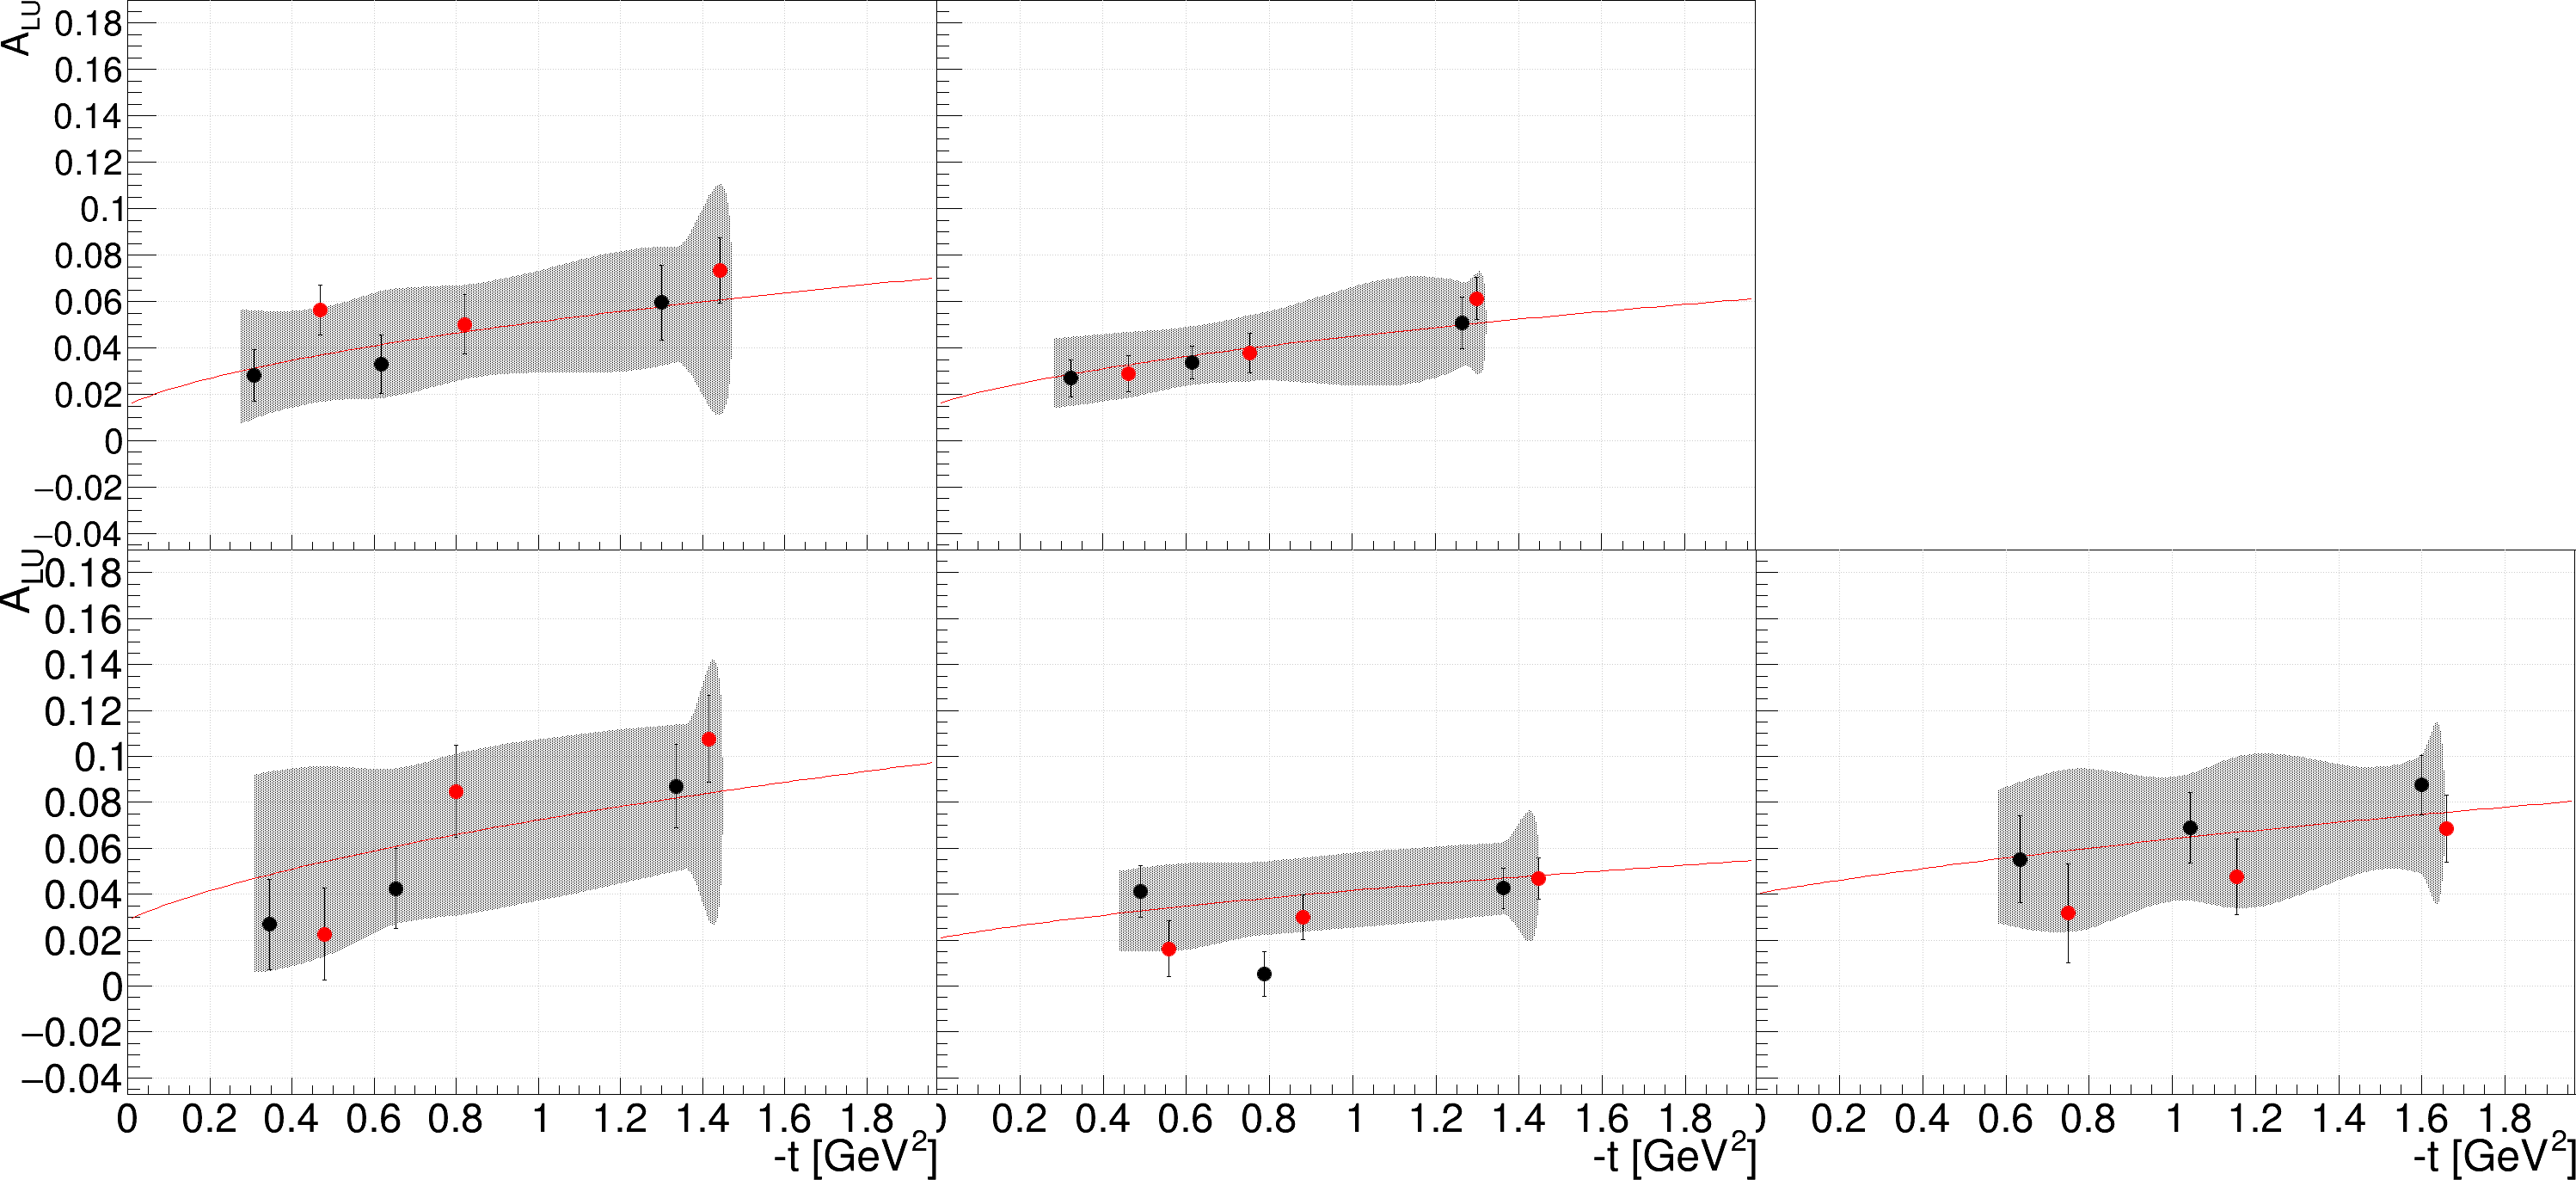

In [7]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

imc,omc = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []
f1s = [ROOT.TF1("f1",line,0,2) for line in ["0.0488*sqrt(x+0.1034)", "0.0422*sqrt(x+0.1403)", "0.0663*sqrt(x+0.1908)", "0.0361*sqrt(x+0.3296)", "0.0497*sqrt(x+0.6594)"]]
if1=ipad=0

for iqdf in imc.qdfs:
    bid = iqdf.binid
    iqdf = imc.shards[bid]
    oqdf = omc.shards[bid]
    
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()

    grstat = ROOT.TGraphErrors()
    for ip in range(maingrs[if1].GetN()):
        xx = maingrs[if1].GetPointX(ip)
        grstat.SetPoint(ip, xx-0.05*(ip==0), f1s[if1].Eval(xx))
        grstat.SetPointError(ip, 0, maingrs[if1].GetErrorY(ip))
    grstat.SetFillColor(1);
    grstat.SetFillStyle(3002);
    grstat.Draw("4")
    grs.append(grstat)

    f1s[if1].SetLineWidth(1)
    f1s[if1].Draw('same')
    if1+=1

    gr0.Draw("P")
    gr1.Draw("P")

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)
    gr1.SetMarkerColor(2)


c1.Print("pdf/MC_injected_asymmetry.aaorad.tdep.pdf")

____________________
### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


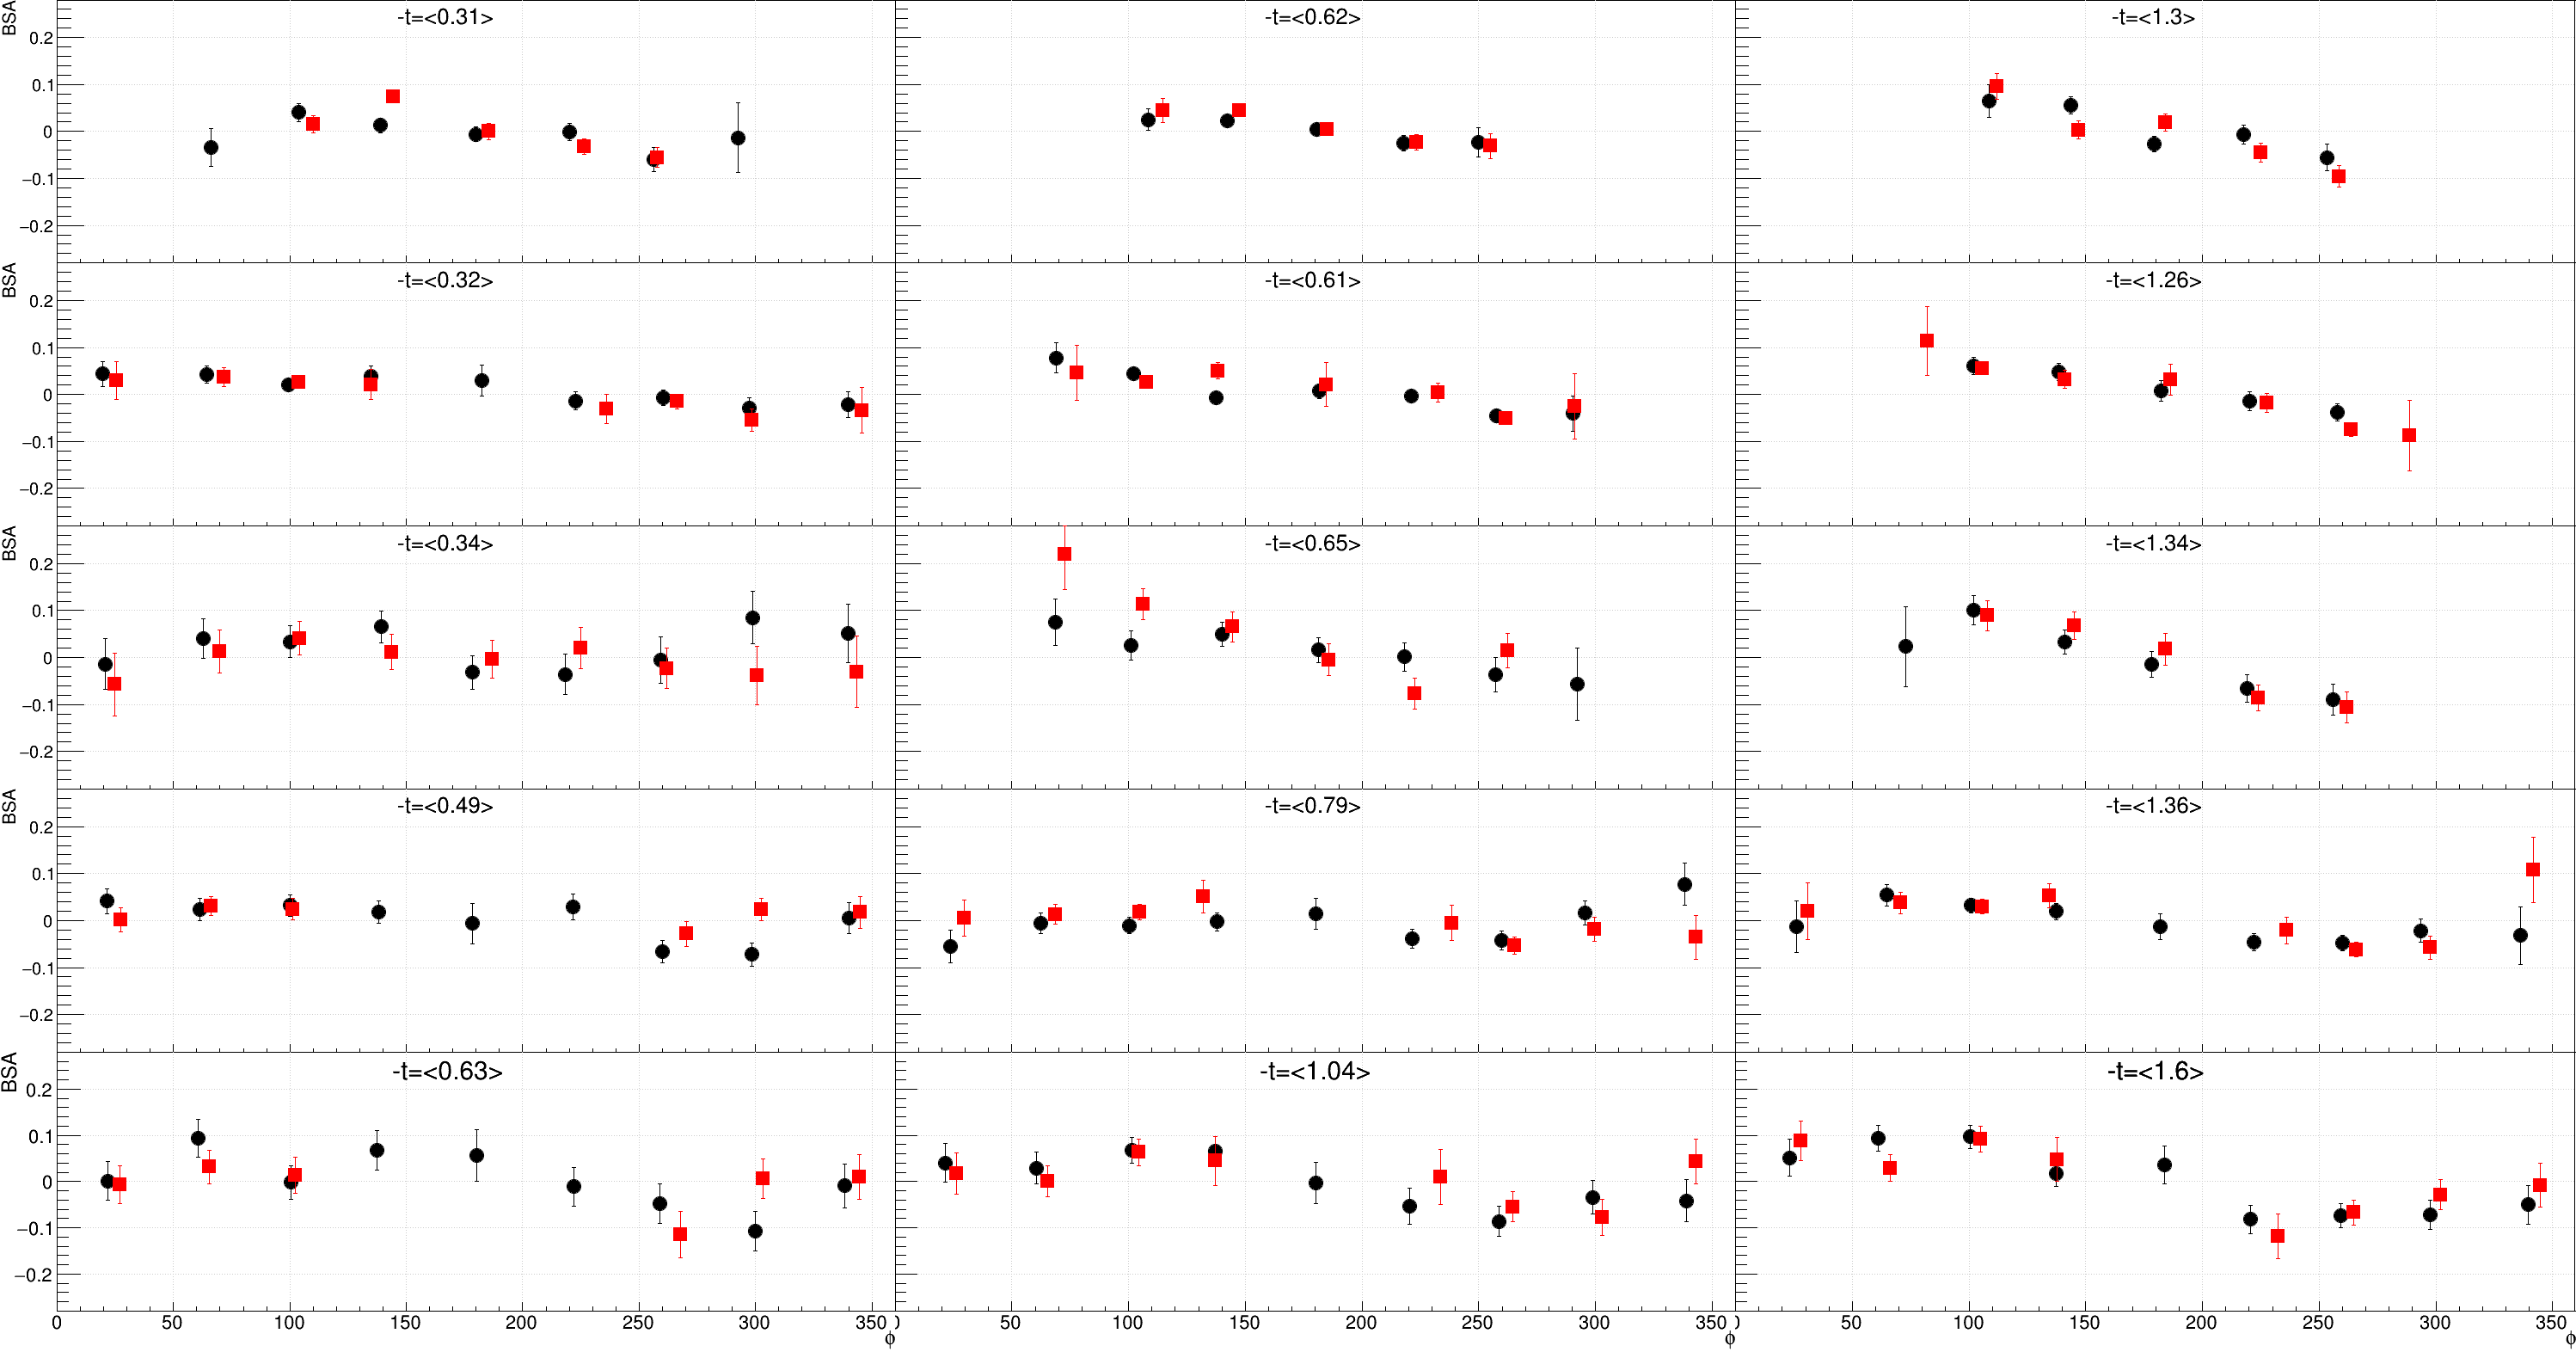

In [8]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

imc,omc = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)

grs = []

ipad=0
for iqdf in imc.qdfs:
    for itdf in iqdf.tdfs:
        bid = itdf.binid
        otdf = omc.shards[bid]

        ipad+=1
        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(itdf.tt,2)}>;#phi;BSA")
        
        gr0, gr1 = itdf.grbsa.Clone(), xshift(otdf.grbsa.Clone(), 5)

        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)
        

________________________________

________________________________

________________________________

# Flat injection

In [9]:
%reset -f

import ROOT, numpy

ROOT.gErrorIgnoreLevel = ROOT.kWarning

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)

ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetPadRightMargin(0.01)
ROOT.gStyle.SetPadLeftMargin(0.075)
ROOT.gStyle.SetPadBottomMargin(0.12)

ROOT.gStyle.SetTitleFont(42,'xy')
ROOT.gStyle.SetTitleFont(42,'T')
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetTitleSize(0.1, 'T')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.58, 'Y')
ROOT.gStyle.SetLabelFont(42,'xy')
ROOT.gStyle.SetLabelSize(0.07, 'XY')

ROOT.gStyle.SetMarkerSize(2)
ROOT.TH1.AddDirectory(0)


%run -i eppi0_columns.py
%run -i eppi0_binning_scheme_v3.py
%run -i eppi0_bsa.py


dfs = []

for fname in ["data/lvl2_eppi0.inb.mc.smear.eloss.root","data/lvl2_eppi0.outb.mc.smear.eloss.root"]:
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)

    cut = "&&".join(f"(((int)status)&(1<<{i}))" for i in [ecloose,prodc,gloosest])
    cut += "&& abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4"
    cut += "&& abs(dpt)<0.3"
    cut += "&& thp<44.106+-6.625*pp+1.438*pp*pp"

    df = df.Filter(cut)
    df = define_eppi0_bins(df, fname)
    
    if 'ihel' not in list(df.GetColumnNames()):
        pb = 0.86 if 'inb' in fname else 0.89
        df = df.Define("ihel", f"""
        gRandom->Rndm()>(0.5*(1+{pb}*0.1*sin(phistar0*TMath::DegToRad()))) ? 1 : -1
        """)

    df = process_eppi0_bins(df,fname)
    dfs.append(df)



rdfs = [] 
for rdf in dfs:
    make_allbsas(rdf)
    rdfs.append(rdf)


In [10]:
def xshift(gr0, dx=0):
    for i in range(gr0.GetN()):
        gr0.SetPointX(i, gr0.GetPointX(i)+dx)
    return gr0



with open("main.output.data") as ff:
    grsdata = eval(ff.read())

maingrs = []
for grdata in grsdata:
    gr = ROOT.TGraphErrors()
    for x,y,dy in grdata:
        gr.SetPoint(gr.GetN(), x, y)
        gr.SetPointError(gr.GetN()-1, 0, dy)
    gr.Sort()
    maingrs.append(gr)
    

_________________________________________________
### $A_{LU}$ vs $-t$ for each $\{Q^2,x_B\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


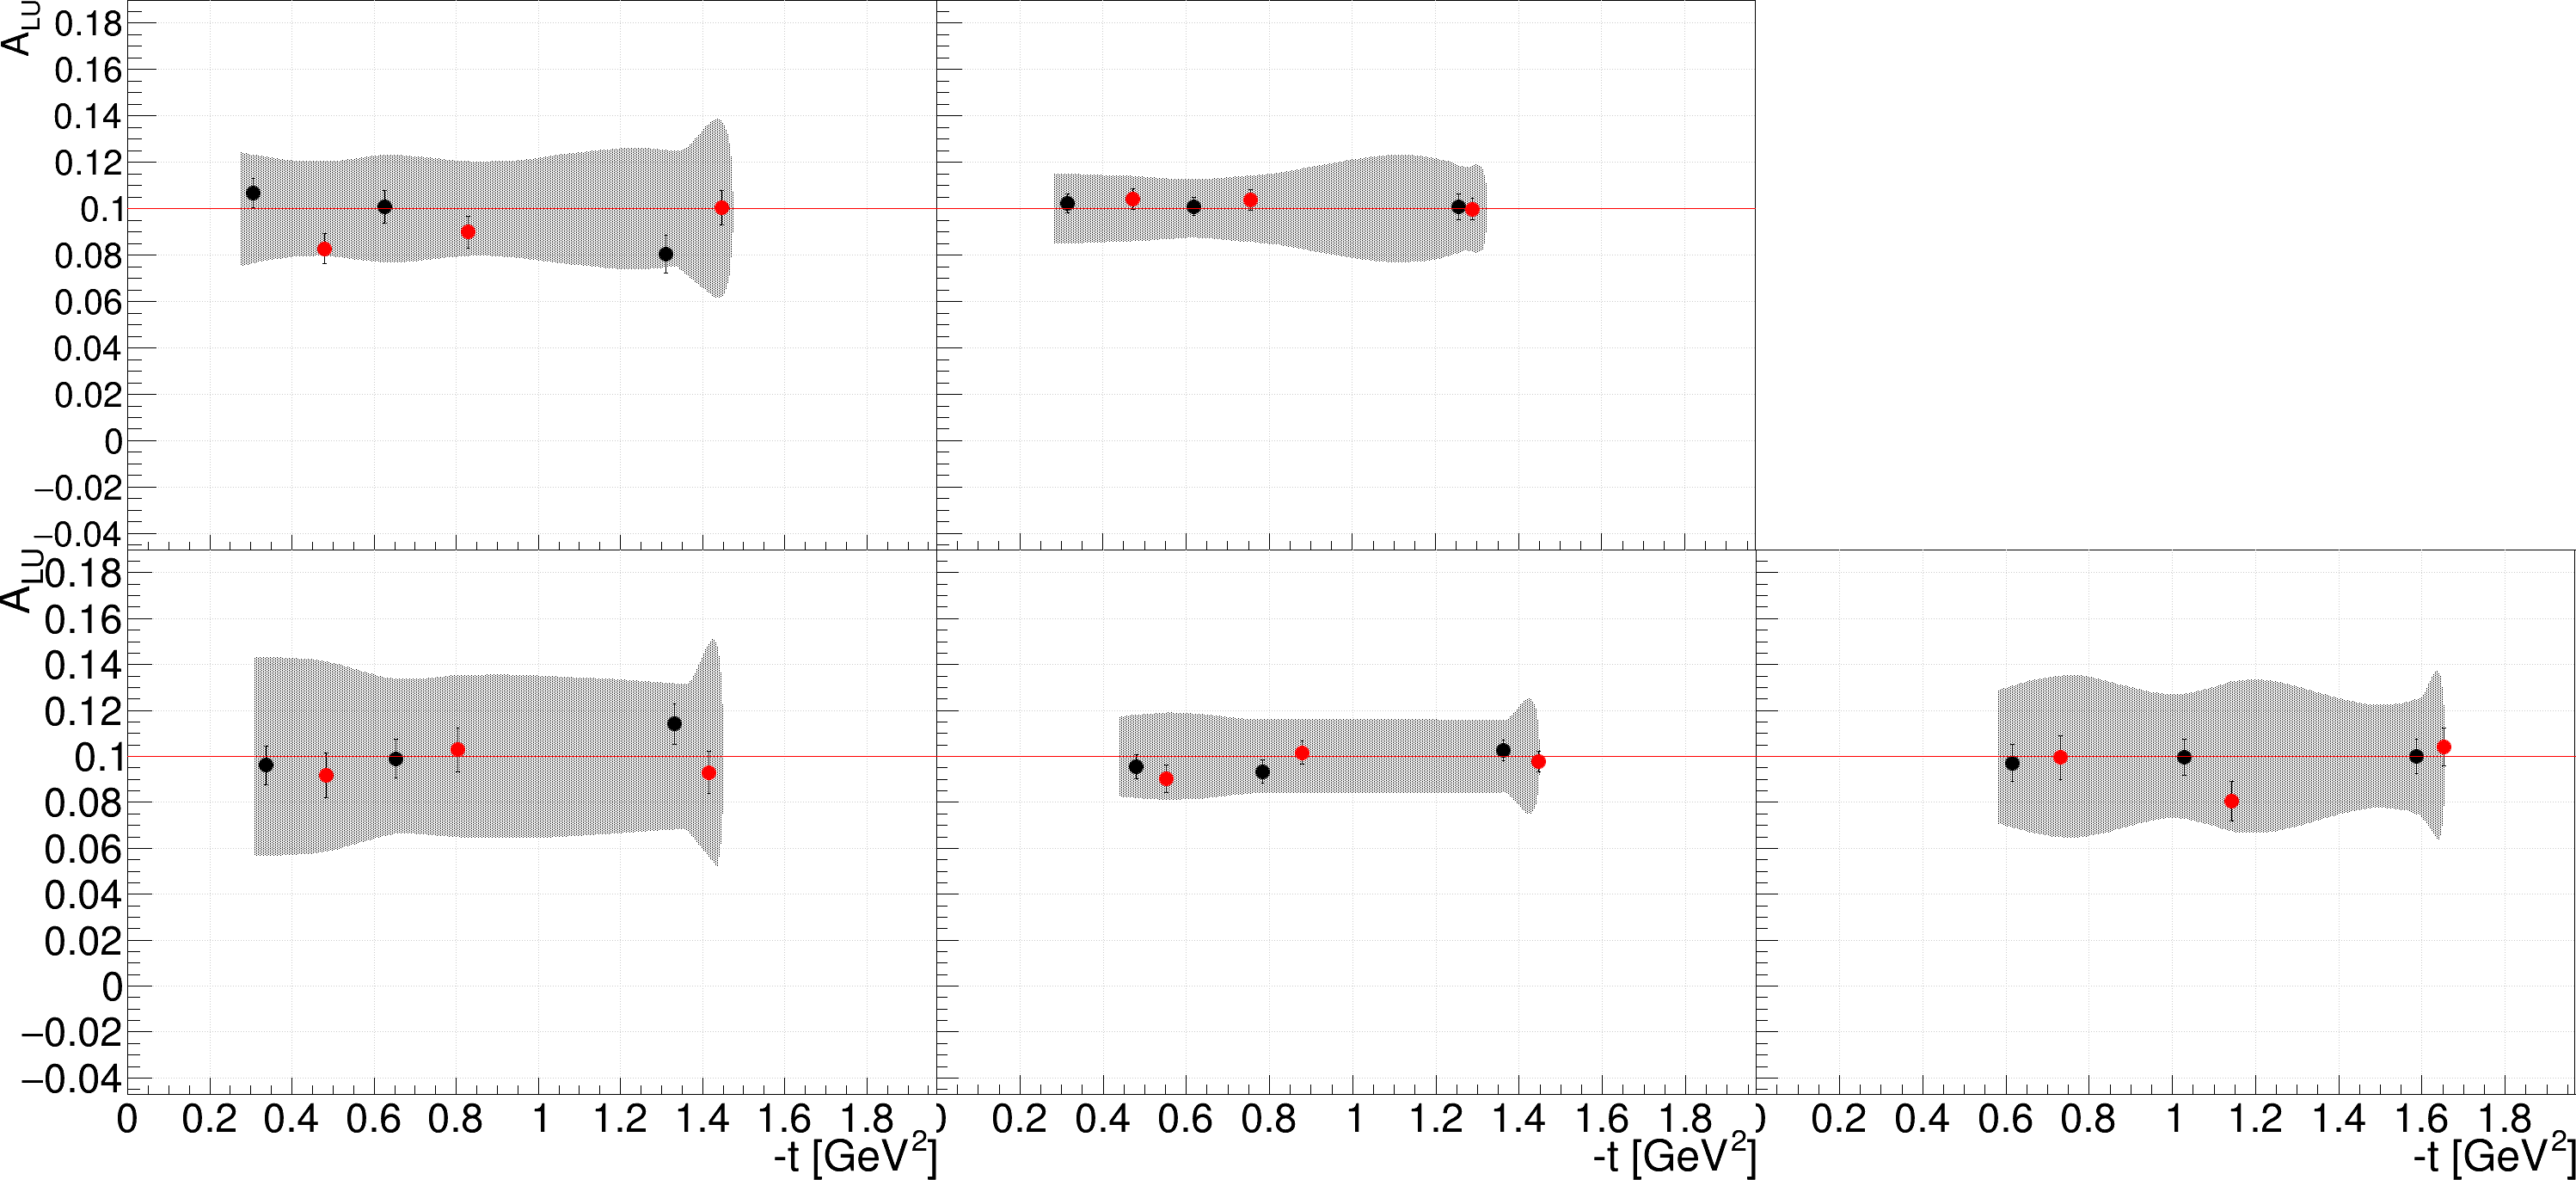

In [11]:
ROOT.gStyle.SetTitleOffset(0.96, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.12)

imc,omc = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1400)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

grs = []
ll = ROOT.TLine()
ll.SetLineColor(2)
ll.SetLineWidth(1)

if1=ipad=0
for iqdf in imc.qdfs:
    bid = iqdf.binid
    iqdf = imc.shards[bid]
    oqdf = omc.shards[bid]
    
    ipad += 2 if ipad==2 else 1
    if ipad==2: c1.cd(ipad).SetRightMargin(0.001)

    h1 = c1.cd(ipad).DrawFrame(0,-0.047,1.97,0.19)
    h1.SetTitle(";-t [GeV^{2}];A_{LU}");

    gr0, gr1 = iqdf.grp1.Clone(), oqdf.grp1.Clone()

    grstat = ROOT.TGraphErrors()
    for ip in range(maingrs[if1].GetN()):
        xx = maingrs[if1].GetPointX(ip)
        grstat.SetPoint(ip, xx-0.05*(ip==0), 0.1)
        grstat.SetPointError(ip, 0, maingrs[if1].GetErrorY(ip))
    grstat.SetFillColor(1);
    grstat.SetFillStyle(3002);
    grstat.Draw("4")
    grs.append(grstat)
    if1+=1

    gr0.Draw("P")
    gr1.Draw("P")
    ll.DrawLine(0,0.1,2,0.1)

    gr0.SetMarkerStyle(20)
    gr1.SetMarkerStyle(20)
    gr1.SetMarkerColor(2)
    
#c1.Print("pdf/MC_injected_asymmetry.flat.pdf")

____________________
### BSA graphs for each $\{Q^2,x_B,-t\}$ bin

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


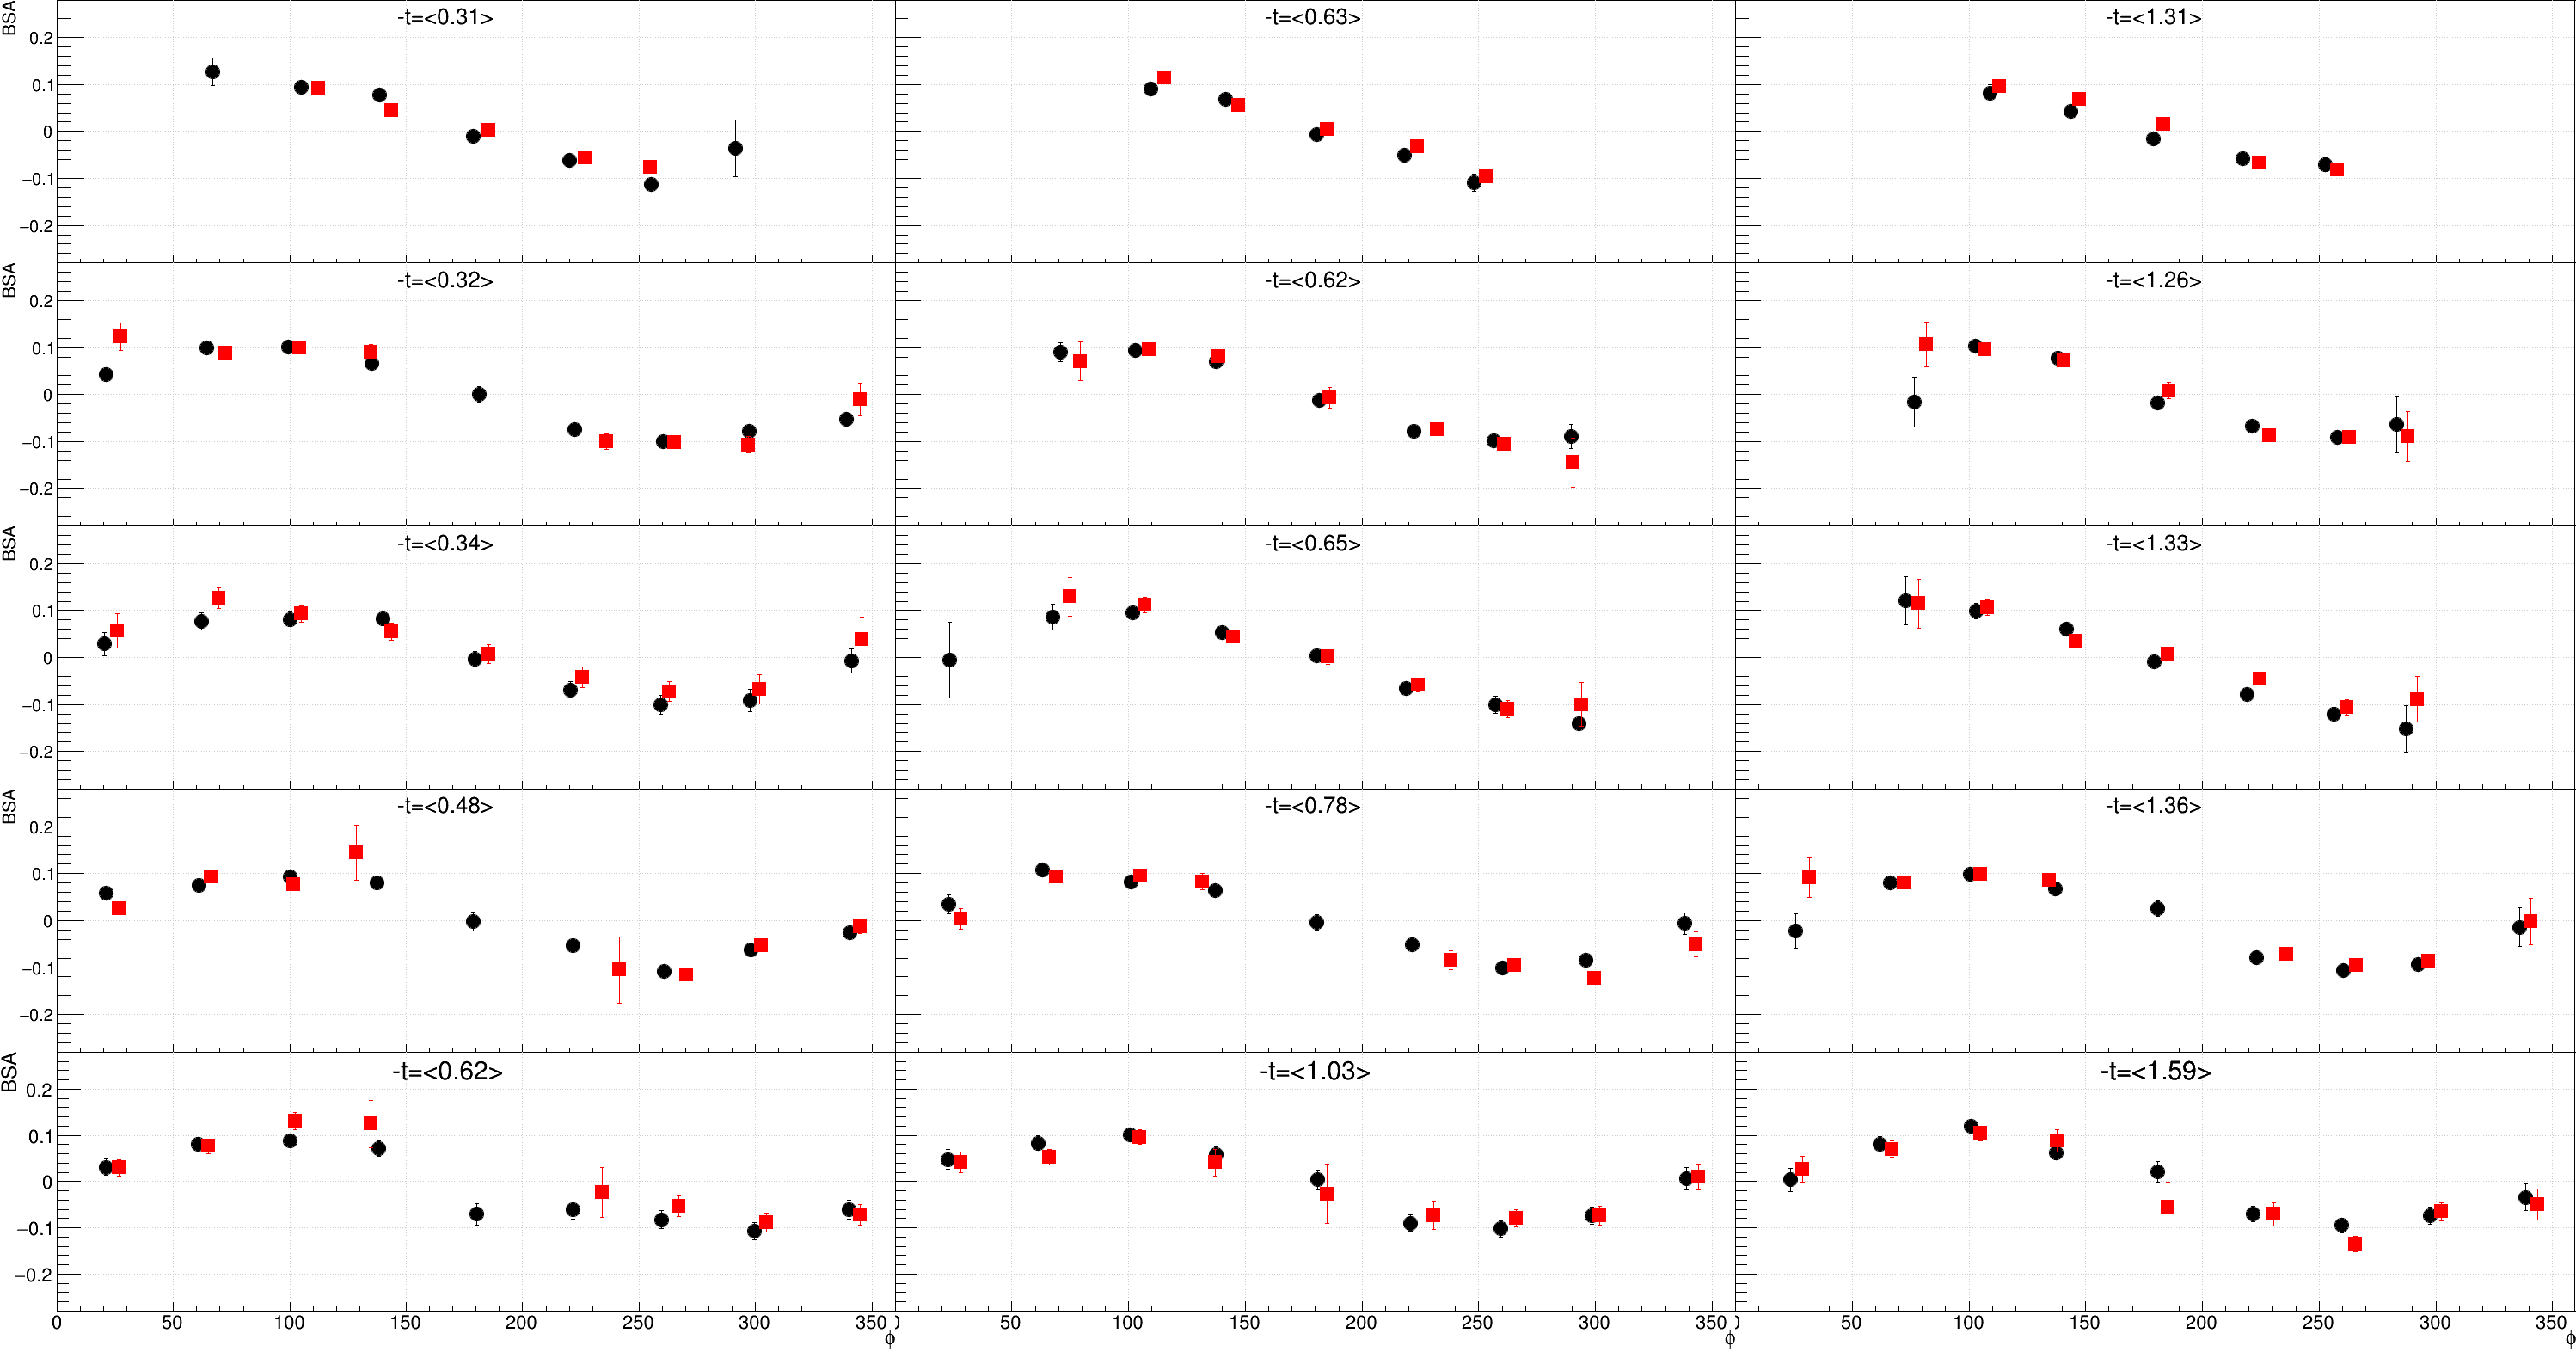

In [12]:
ROOT.gStyle.SetTitleOffset(0.45, 'Y')
ROOT.gStyle.SetPadLeftMargin(0.06)

imc,omc = rdfs

c1 = ROOT.TCanvas("c1","c1",3000,1600)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,5,0,0)

grs = []

ipad=0
for qdf in imc.qdfs:
    for tdf in qdf.tdfs:
        bid = tdf.binid
        tdf1 = omc.shards[bid]

        ipad+=1
        h1 = c1.cd(ipad).DrawFrame(0,-0.28,360,0.28)
        h1.SetTitle(f"-t=<{round(tdf.tt,2)}>;#phi;BSA")
        
        gr0, gr1 = tdf.grbsa.Clone(), xshift(tdf1.grbsa.Clone(), 5)

        gr0.Draw("P")
        gr1.Draw("P")
        
        gr0.SetMarkerStyle(20)
        gr1.SetMarkerStyle(21)
        gr1.SetMarkerColor(2)
        gr1.SetLineColor(2)
        

________________________________

________________________________

________________________________